In [1]:
import pandas as pd
import numpy as np
import itertools
import igraph
import sys
import collections
import datetime
import random
import itertools

In [2]:
period = 'EV'
trial = 0

In [3]:
root = '/Volumes/Data2/RST/notebook/'

#root = 'D:/RST/notebook/'

In [4]:
G_tt = igraph.Graph.Read_GraphML(f = root + 'networks/' + period + '-TE-16-8.graphml')

# Loading the OD Zones

In [5]:
od_data = pd.read_csv(root + 'TTS OD/LICO_TTS.csv')
od_data['origin'] = od_data['origin'] + 1000
od_data['destination'] = od_data['destination'] + 1000

depart_hour = '-20-'
rand_time = []

for i in range(6):
    minute = random.randint(0,9)
    minute = minute + i*10
    rand_time.append(depart_hour + str(minute))
rand_time[0]

'-20-3'

# Creating a Key for Node IDs and Node Names

In [6]:
node_key_table = []

for i in G_tt.vs:
    node_key_table.append([i.index,  i['id']])
node_df = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

In [7]:
node_df['INT_ID'] = node_df['node_id'].str.split('-', expand = True)[0]
node_df['node_time'] = node_df['node_id'].str.split(
    '-', expand = True)[0] + '-' + node_df['node_id'].str.split(
    '-', expand = True)[2] + '-' + node_df['node_id'].str.split('-', expand = True)[3]
node_dict = node_df[['INT_ID']].to_dict()['INT_ID']
time_dict = node_df[['node_time']].to_dict()['node_time']

In [8]:
node_data = od_data[od_data['type'] == 'raw_' + period.lower()][['origin', 'destination']].copy()
node_data['origin'] = node_data['origin'].astype(str)
node_data['destination'] = node_data['destination'].astype(str)
node_data['o_node'] = node_data['origin'] + '-0' + rand_time[trial]
node_data['d_node'] = node_data['destination'] + '-0-99-99'
node_data

,origin,destination,o_node,d_node
6,1001,1272,1001-0-20-3,1272-0-99-99
19,1003,1270,1003-0-20-3,1270-0-99-99
21,1003,1572,1003-0-20-3,1572-0-99-99
26,1004,1166,1004-0-20-3,1166-0-99-99
29,1004,1251,1004-0-20-3,1251-0-99-99
...,...,...,...,...
23750,1613,1578,1613-0-20-3,1578-0-99-99
23753,1613,1604,1613-0-20-3,1604-0-99-99
23762,1614,1622,1614-0-20-3,1622-0-99-99
23769,1616,1245,1616-0-20-3,1245-0-99-99


In [9]:
o_list = list(node_df[node_df['node_id'].isin(node_data['o_node'])]['index'])
d_list = list(node_df[node_df['node_id'].isin(node_data['d_node'])]['index'])

out_all = G_tt.shortest_paths(o_list, d_list, weights = 'cost',  mode = 'out')

In [10]:
table = []
for i in range(len(o_list)):
    temp_lst = out_all[i]
    for j in range(len(d_list)):
        table.append([o_list[i], d_list[j], temp_lst[j]])

In [11]:
base_time_df = pd.DataFrame.from_records(table, columns = ['o_id', 'd_id', 'base_time'])
base_time_df = base_time_df.merge(node_df, left_on = ['o_id'], right_on = 'index', how = 'left').rename(
    columns = {'node_id':'o_node'})[['o_node','d_id','base_time']].merge(
    node_df, left_on = ['d_id'], right_on = 'index', how = 'left').rename(
    columns = {'node_id':'d_node'})[['o_node','d_node','base_time']]
node_data = node_data.merge(base_time_df, how = 'left')

In [12]:
node_data.sort_values(by = 'base_time')

,origin,destination,o_node,d_node,base_time
303,1050,1038,1050-0-20-3,1038-0-99-99,5.0
226,1043,1043,1043-0-20-3,1043-0-99-99,8.0
1443,1445,1445,1445-0-20-3,1445-0-99-99,8.0
1505,1487,1487,1487-0-20-3,1487-0-99-99,10.0
995,1171,1172,1171-0-20-3,1172-0-99-99,10.0
...,...,...,...,...,...
1221,1260,1383,1260-0-20-3,1383-0-99-99,128.0
1592,1566,1334,1566-0-20-3,1334-0-99-99,132.0
1584,1564,1313,1564-0-20-3,1313-0-99-99,133.0
1297,1290,1570,1290-0-20-3,1570-0-99-99,135.0


In [13]:
# removing np.inf

node_data = node_data[node_data['base_time'] != np.inf]
node_data.sort_values(by = 'base_time')

,origin,destination,o_node,d_node,base_time
303,1050,1038,1050-0-20-3,1038-0-99-99,5.0
226,1043,1043,1043-0-20-3,1043-0-99-99,8.0
1443,1445,1445,1445-0-20-3,1445-0-99-99,8.0
1505,1487,1487,1487-0-20-3,1487-0-99-99,10.0
995,1171,1172,1171-0-20-3,1172-0-99-99,10.0
...,...,...,...,...,...
1221,1260,1383,1260-0-20-3,1383-0-99-99,128.0
1592,1566,1334,1566-0-20-3,1334-0-99-99,132.0
1584,1564,1313,1564-0-20-3,1313-0-99-99,133.0
1297,1290,1570,1290-0-20-3,1570-0-99-99,135.0


In [14]:
node_data['buffer_length'] = np.where(node_data['base_time'] < 30, 5, 5 + (1/9 * (node_data['base_time'] - 30)))
node_data['buffer_length'] = np.where(node_data['base_time'] < 120, node_data['buffer_length'], 15)

<AxesSubplot:xlabel='base_time', ylabel='buffer_length'>

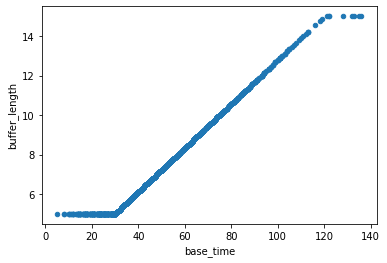

In [15]:
node_data.plot(x = 'base_time', y = 'buffer_length', kind = 'scatter')

In [17]:
node_data

,origin,destination,o_node,d_node,base_time,buffer_length
0,1001,1272,1001-0-20-3,1272-0-99-99,41.0,6.222222
1,1003,1270,1003-0-20-3,1270-0-99-99,18.0,5.000000
2,1003,1572,1003-0-20-3,1572-0-99-99,107.0,13.555556
3,1004,1166,1004-0-20-3,1166-0-99-99,66.0,9.000000
4,1004,1251,1004-0-20-3,1251-0-99-99,46.0,6.777778
...,...,...,...,...,...,...
1652,1613,1578,1613-0-20-3,1578-0-99-99,17.0,5.000000
1653,1613,1604,1613-0-20-3,1604-0-99-99,25.0,5.000000
1654,1614,1622,1614-0-20-3,1622-0-99-99,42.0,6.333333
1655,1616,1245,1616-0-20-3,1245-0-99-99,81.0,10.666667


In [18]:

node_data['cutoff_time'] = node_data['base_time'] + node_data['buffer_length']



node_data['arrival_time'] = round(node_data['o_node'].str.split('-', expand = True)[3].astype(int) + node_data['cutoff_time'])
node_data

,origin,destination,o_node,d_node,base_time,buffer_length,cutoff_time,arrival_time
0,1001,1272,1001-0-20-3,1272-0-99-99,41.0,6.222222,47.222222,50.0
1,1003,1270,1003-0-20-3,1270-0-99-99,18.0,5.000000,23.000000,26.0
2,1003,1572,1003-0-20-3,1572-0-99-99,107.0,13.555556,120.555556,124.0
3,1004,1166,1004-0-20-3,1166-0-99-99,66.0,9.000000,75.000000,78.0
4,1004,1251,1004-0-20-3,1251-0-99-99,46.0,6.777778,52.777778,56.0
...,...,...,...,...,...,...,...,...
1652,1613,1578,1613-0-20-3,1578-0-99-99,17.0,5.000000,22.000000,25.0
1653,1613,1604,1613-0-20-3,1604-0-99-99,25.0,5.000000,30.000000,33.0
1654,1614,1622,1614-0-20-3,1622-0-99-99,42.0,6.333333,48.333333,51.0
1655,1616,1245,1616-0-20-3,1245-0-99-99,81.0,10.666667,91.666667,95.0


In [19]:
node_data['arrival_hour'] = (node_data['arrival_time']/60).astype(int) + int(depart_hour.split('-')[1])

node_data['arrival_hour'] = np.where(node_data['arrival_hour'] >=24, node_data['arrival_hour']-24, node_data['arrival_hour'])

In [20]:
node_data['arrival_minute'] = node_data['arrival_time'] - (node_data['arrival_hour'] - int(depart_hour.split('-')[1]))*60
node_data

,origin,destination,o_node,d_node,base_time,buffer_length,cutoff_time,arrival_time,arrival_hour,arrival_minute
0,1001,1272,1001-0-20-3,1272-0-99-99,41.0,6.222222,47.222222,50.0,20,50.0
1,1003,1270,1003-0-20-3,1270-0-99-99,18.0,5.000000,23.000000,26.0,20,26.0
2,1003,1572,1003-0-20-3,1572-0-99-99,107.0,13.555556,120.555556,124.0,22,4.0
3,1004,1166,1004-0-20-3,1166-0-99-99,66.0,9.000000,75.000000,78.0,21,18.0
4,1004,1251,1004-0-20-3,1251-0-99-99,46.0,6.777778,52.777778,56.0,20,56.0
...,...,...,...,...,...,...,...,...,...,...
1652,1613,1578,1613-0-20-3,1578-0-99-99,17.0,5.000000,22.000000,25.0,20,25.0
1653,1613,1604,1613-0-20-3,1604-0-99-99,25.0,5.000000,30.000000,33.0,20,33.0
1654,1614,1622,1614-0-20-3,1622-0-99-99,42.0,6.333333,48.333333,51.0,20,51.0
1655,1616,1245,1616-0-20-3,1245-0-99-99,81.0,10.666667,91.666667,95.0,21,35.0


In [21]:
node_data['constrained_node'] = node_data['destination'].astype(str) + '-9999-' + node_data['arrival_hour'].astype(
    str) + '-' + node_data['arrival_minute'].astype(int).astype(str)

In [37]:
#del G_tt
#del node_df

G = igraph.Graph.Read_GraphML(f = root + 'networks/' + period + '-TE-16-5-constrained.graphml')

In [39]:
#del node_key_table

node_key_table = []

for i in G.vs:
    node_key_table.append([i.index,  i['id']])
node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

del node_key_table
node_df_new

,index,node_id
0,0,13460822-0-20-0
1,1,13460822-0-20-1
2,2,13460822-0-20-2
3,3,13460822-0-20-3
4,4,13460822-0-20-4
...,...,...
2098595,2098595,1081-3-1-25
2098596,2098596,1081-3-1-26
2098597,2098597,1081-3-1-27
2098598,2098598,1081-3-1-28


In [40]:
node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0]
node_df_new['route'] = node_df_new['node_id'].str.split('-', expand = True)[1]

In [41]:
node_df_new['route_int'] = node_df_new['INT_ID'] + '-' + node_df_new['route']
node_df_new

,index,node_id,INT_ID,route,route_int
0,0,13460822-0-20-0,13460822,0,13460822-0
1,1,13460822-0-20-1,13460822,0,13460822-0
2,2,13460822-0-20-2,13460822,0,13460822-0
3,3,13460822-0-20-3,13460822,0,13460822-0
4,4,13460822-0-20-4,13460822,0,13460822-0
...,...,...,...,...,...
2098595,2098595,1081-3-1-25,1081,3,1081-3
2098596,2098596,1081-3-1-26,1081,3,1081-3
2098597,2098597,1081-3-1-27,1081,3,1081-3
2098598,2098598,1081-3-1-28,1081,3,1081-3


In [42]:
node_dict_new = node_df_new[['INT_ID']].to_dict()['INT_ID']
route_dict_new = node_df_new[['INT_ID', 'route']].to_dict()['route']

In [43]:
node_data[node_data['cutoff_time'] < 170].sort_values(by = 'cutoff_time').tail()

,origin,destination,o_node,d_node,base_time,buffer_length,cutoff_time,arrival_time,arrival_hour,arrival_minute,constrained_node
1221,1260,1383,1260-0-20-3,1383-0-99-99,128.0,15.0,143.0,146.0,22,26.0,1383-9999-22-26
1592,1566,1334,1566-0-20-3,1334-0-99-99,132.0,15.0,147.0,150.0,22,30.0,1334-9999-22-30
1584,1564,1313,1564-0-20-3,1313-0-99-99,133.0,15.0,148.0,151.0,22,31.0,1313-9999-22-31
1297,1290,1570,1290-0-20-3,1570-0-99-99,135.0,15.0,150.0,153.0,22,33.0,1570-9999-22-33
1585,1564,1371,1564-0-20-3,1371-0-99-99,136.0,15.0,151.0,154.0,22,34.0,1371-9999-22-34


In [51]:
row_no = 2

origin = node_data.loc[row_no,'o_node']
dest = node_data.loc[row_no,'constrained_node']

o = G.vs.select(id_eq = origin)[0]
d = G.vs.select(id_eq = dest)[0]

o_str = node_data.loc[row_no,'origin']
d_str = node_data.loc[row_no,'destination']

IndexError: vertex index out of range

In [47]:
origin

'1001-0-20-3'

In [53]:
G.vs.select(id_eq = '1383-0-22-26')[0]

igraph.Vertex(<igraph.Graph object at 0x7f9f68521450>, 1762298, {'id': '1383-0-22-26'})

In [25]:
o, o_str

(igraph.Vertex(<igraph.Graph object at 0x7f9b63bba450>, 1781528, {'id': '1624-0-7-3'}),
 '1624')

In [26]:
d, d_str

(igraph.Vertex(<igraph.Graph object at 0x7f9b63bba450>, 2093498, {'id': '1371-9999-9-44'}),
 '1371')

In [27]:
out = G.get_all_shortest_paths(o, d, weights = 'cost',  mode = 'out')

In [28]:
len(out)

88944

In [29]:
table = []
#full_table = []
#route_int_table = []
route_table = []
for path in out:
    temp_list = list(dict.fromkeys(list(map(node_dict_new.get, path))))
    route_list = list(dict.fromkeys(list(map(route_dict_new.get, path))))
    #route_int_list = list(dict.fromkeys(list(map(route_int_dict_new.get, path))))
    #full_list = list(set(map(full_dict_new.get, path)))
    table.append(temp_list)
    route_table.append(route_list)
    #route_int_table.append(route_int_list)
    #full_table.append(full_list)

In [30]:
route_table.sort()
route_table_sort = list(x for x,_ in itertools.groupby(route_table))

In [31]:
table.sort()
table_sort = list(x for x,_ in itertools.groupby(table))

In [32]:
# full_table.sort()
# full_table_sort = list(x for x,_ in itertools.groupby(full_table))

In [33]:
# route_int_table.sort()
# route_int_table_sort = list(x for x,_ in itertools.groupby(route_int_table))

In [34]:
len(table_sort), len(route_table_sort)

(1129, 681)

In [35]:
route_df = pd.DataFrame(pd.Series(route_table_sort), columns = ['route']).reset_index().rename(
    columns = {'index':'path'}).explode('route')
route_df['route'] = route_df['route'].astype(int)
route_df = route_df[~route_df['route'].isin([0,9999])]
route_df.to_csv(period + '/' + str(trial) + '/route-path_'+ o_str + '_' + d_str + '.csv', index = False)
route_df

,path,route
0,0,85
0,0,102
0,0,116
0,0,9086
0,0,2
...,...,...
679,679,191
680,680,9086
680,680,9131
680,680,2


In [36]:
# path_df = pd.DataFrame(pd.Series(full_table_sort), columns = ['node_id']).reset_index().rename(
#     columns = {'index':'path'}).explode('node_id')
# path_df.to_csv('sample_output.csv', index = False)

In [37]:
table_df = pd.DataFrame(pd.Series(table_sort), columns = ['INT_ID']).reset_index().rename(
    columns = {'index':'path'}).explode('INT_ID')
table_df.to_csv(period + '/' + str(trial) + '/int-path_'+ o_str + '_' + d_str + '.csv', index = False)

In [38]:
table_df

,path,INT_ID
0,0,1624
0,0,13442597
0,0,13442679
0,0,13442521
0,0,13442623
...,...,...
1128,1128,13454935
1128,1128,13453882
1128,1128,20232392
1128,1128,13453590


In [39]:
del table_df
del route_df
del table
del route_table
del out

In [ ]:
# route_int_df = pd.DataFrame(pd.Series(route_int_table_sort), columns = ['route_int']).reset_index().rename(
#     columns = {'index':'path'}).explode('route_int')
# route_int_df.to_csv('sample_route_int_table.csv', index = False)

In [ ]:
# route_int_df['INT_ID'] = route_int_df['route_int'].str.split('-', expand = True)[0].astype(int)
# route_int_df['route'] = route_int_df['route_int'].str.split('-', expand = True)[1].astype(int)
# route_int_df = route_int_df.drop(columns = ['route_int'])